## 환경 설정 및 데이터 불러오기

In [1]:
%pip install pandas
%pip install datasets
%pip install transformers
%pip install torch
%pip install evaluate
%pip install 'transformers[torch]'
%pip install accelerate
%pip install tf-keras
%pip install wordcloud
%pip install nltk
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
# # pip freeze

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from datasets import Dataset
from transformers import AutoTokenizer # 토크나이저, GPU
from transformers import AutoModelForSequenceClassification # 모델 로드
from transformers import Trainer, TrainingArguments # 모델 학습
from transformers import AdamW # 옵티마이저
from transformers import CrossEntropyLoss # 손실 함수
from transformers import pipeline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import torch
from torch.utils.data import DataLoader
import evaluate

from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# # NLTK 데이터 다운로드 경로 지정
nltk_data_dir = '/data/ephemeral/home/imdb/imdbenv/nltk_data'
nltk.data.path = []
tokenizers_dir = os.path.join(nltk_data_dir, 'tokenizers')

nltk.data.path.append(nltk_data_dir)
nltk.data.path.insert(0, nltk_data_dir)  # 최우선 검색 경로로 추가

# 필요한 NLTK 데이터 다운로드
try:
    nltk.download('punkt', download_dir=nltk_data_dir)
    nltk.download('punkt_tab', download_dir=nltk_data_dir)
    nltk.download('averaged_perceptron_tagger', download_dir=nltk_data_dir)
    nltk.download('maxent_ne_chunker', download_dir=nltk_data_dir)
    nltk.download('words', download_dir=nltk_data_dir)
    nltk.download('stopwords', download_dir=nltk_data_dir)
    nltk.download('wordnet', download_dir=nltk_data_dir)
    
    print("NLTK 데이터 다운로드 완료!")
except Exception as e:
    print(f"다운로드 중 에러 발생: {e}")

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'


ImportError: cannot import name 'CrossEntropyLoss' from 'transformers' (/data/ephemeral/home/imdb/imdbenv/lib/python3.10/site-packages/transformers/__init__.py)

In [3]:
import nltk
print(nltk.data.path)

['/data/ephemeral/home/imdb/imdbenv/nltk_data', '/data/ephemeral/home/imdb/imdbenv/nltk_data']


In [4]:
data = pd.read_csv('IMDB_Dataset.csv')

In [5]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## 1. EDA

In [7]:
print(data.head())
print("\n")
print(data.info())
print("\n")
print(data.describe())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                               

In [6]:
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

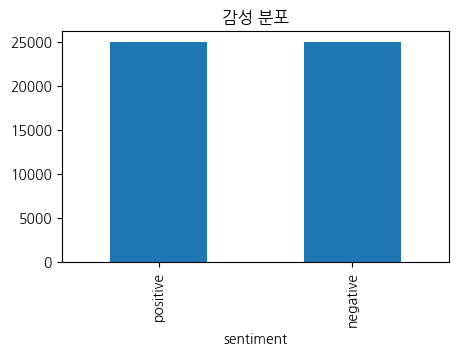

In [8]:
# 감성 분포
plt.figure(figsize=(5, 3))
data['sentiment'].value_counts().plot(kind='bar')
plt.title("감성 분포")
plt.show()

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length, dtype: float64


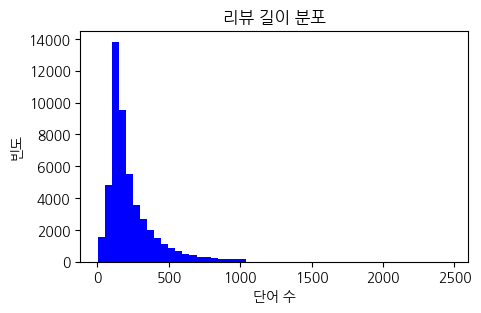

In [9]:
# 텍스트 길이 계산
data['review_length'] = data['review'].apply(lambda x: len(x.split()))

# 리뷰 길이 통계
print(data['review_length'].describe())

# 리뷰 길이 분포
plt.figure(figsize=(5, 3))
plt.hist(data['review_length'], bins=50, color='blue')
plt.title('리뷰 길이 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.show()

In [10]:
positive_reviews = data[data['sentiment'] == 'positive']['review']
negative_reviews = data[data['sentiment'] == 'negative']['review']

In [11]:
# Tokenize and count words
positive_words = Counter([word for review in positive_reviews for word in word_tokenize(review.lower())])
negative_words = Counter([word for review in negative_reviews for word in word_tokenize(review.lower())])

# Most common positive words
print(positive_words.most_common(10))

# Most common negative words
print(negative_words.most_common(10))

[('the', 339238), (',', 282003), ('.', 230821), ('and', 175937), ('a', 163442), ('of', 151671), ('to', 130801), ('is', 114193), ('in', 98409), ('/', 98198)]
[('the', 324975), (',', 262027), ('.', 233567), ('a', 157812), ('and', 147139), ('of', 136855), ('to', 136232), ('/', 104257), ('>', 104177), ('<', 104100)]


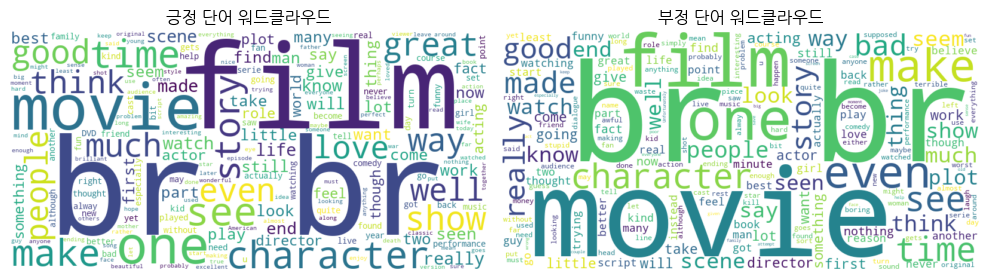

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
# 긍정 단어 워드클라우드
positive_text = ' '.join(positive_reviews)
positive_wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white'
).generate(positive_text)

# 긍정 단어 워드클라우드 시각화
ax1.imshow(positive_wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('긍정 단어 워드클라우드')

# 부정 단어 워드클라우드
negative_text = ' '.join(negative_reviews)
negative_wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white'
).generate(negative_text)

# 부정 단어 워드클라우드 시각화
ax2.imshow(negative_wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('부정 단어 워드클라우드')
plt.tight_layout()
plt.show()

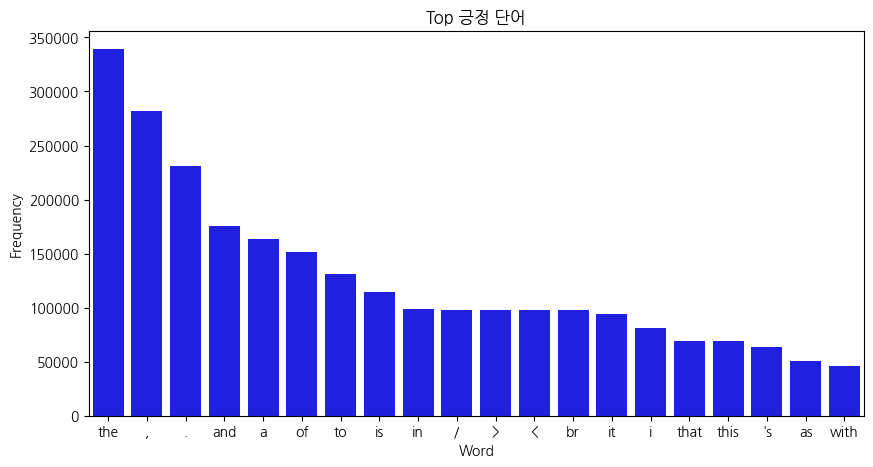

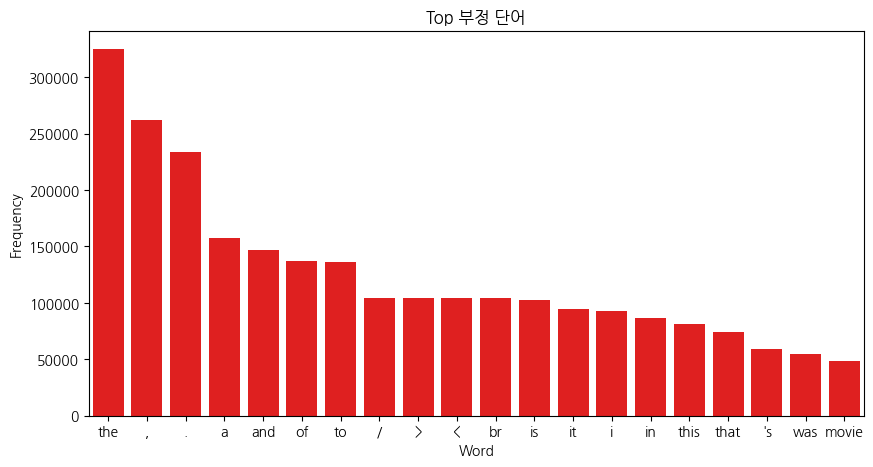

In [13]:
# 감성별 단어 사용 분석
positive_specific = positive_words.most_common(20)
negative_specific = negative_words.most_common(20)

# DataFrame으로 변환
positive_df = pd.DataFrame(positive_specific, columns=['Word', 'Frequency'])
negative_df = pd.DataFrame(negative_specific, columns=['Word', 'Frequency'])

# 긍정 및 부정 단어 사용 시각화
plt.figure(figsize=(10, 5))
sns.barplot(data=positive_df, x='Word', y='Frequency', color='blue')
plt.title('Top 긍정 단어')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=negative_df, x='Word', y='Frequency', color='red')
plt.title('Top 부정 단어')
plt.show()

## 2. 데이터 전처리

#### train test 데이터 분리

In [14]:
# dataset 형태로 변환
dataset = Dataset.from_pandas(data)

# train, test 데이터 분리
dataset = dataset.train_test_split(test_size=0.3)
train = dataset['train']
test = dataset['test']


In [15]:
train[10], test[10]


({'review': "I am still shuddering at the thought of EVER seeing this movie again.<br /><br />I have seen action films, I have even liked quite a few of them, but this one goes over the top.<br /><br />Not only does it have the worst male actor ever (Sly Stallone) playing the lead role, but the plot of the movie is so stupid from the beginning (why not rob the money while the plane is on the ground, would be hell of a lot easier) that it requires a person with IQ less than his shoenumber to believe it. <br /><br />Furthermore, the plot has no real twists at all, a three year old kid could guess what comes next. It is a set of cliches (of action genre), with Sly performing even worse than his other movies (he was better even in Rambo III if you watch that movie as a comedy rather than action film). Now there is an actor who can't act A) surprised B) sad C) anything else than his basic face. <br /><br />I would still like to point out that this movie has two factors that might make some 

#### 텍스트 정제

In [16]:
# 텍스트 정제 함수 정의
def clean_text(text): 
    text = re.sub(r'<.*?>', '', text)  # HTML 태그 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = text.lower()  # 소문자로 변환
    text = text.strip()  # 문자열 양쪽 공백 제거
    text = text.replace('br', '')  # 'br' 태그 제거
        
    return text

# Dataset에 새로운 컬럼 추가하는 함수
def add_cleaned_review(dt):
    return {
        'cleaned_review': clean_text(dt['review']),
        **dt  # 기존 컬럼들 유지
    }

# train과 test 각각에 대해 적용
dataset['train'] = dataset['train'].map(add_cleaned_review)
dataset['test'] = dataset['test'].map(add_cleaned_review)

# 결과 확인
print("Training example:")


Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Training example:


In [17]:
dataset['train'][10], dataset['test'][10]

({'review': "I am still shuddering at the thought of EVER seeing this movie again.<br /><br />I have seen action films, I have even liked quite a few of them, but this one goes over the top.<br /><br />Not only does it have the worst male actor ever (Sly Stallone) playing the lead role, but the plot of the movie is so stupid from the beginning (why not rob the money while the plane is on the ground, would be hell of a lot easier) that it requires a person with IQ less than his shoenumber to believe it. <br /><br />Furthermore, the plot has no real twists at all, a three year old kid could guess what comes next. It is a set of cliches (of action genre), with Sly performing even worse than his other movies (he was better even in Rambo III if you watch that movie as a comedy rather than action film). Now there is an actor who can't act A) surprised B) sad C) anything else than his basic face. <br /><br />I would still like to point out that this movie has two factors that might make some 

#### 토큰화 (선택)

In [ ]:
# (1) 토큰화 함수
def tokenize(dt):
    return {
        'tokens': word_tokenize(dt['cleaned_review']),     # 전처리 전에 토큰화 시, 'review' 컬럼으로 교
        **dt                                               # 기존 컬럼들 유지
    }

# map 메서드를 사용하여 토큰화 적용
train = train.map(tokenize)
test = test.map(tokenize)

# 결과 확인
train[10], test[10]

In [ ]:
# Hugginc Face tinybert  huawei-noah 모델 
# model = 'huawei-noah/TinyBERT_General_4L_312D'
# tokenizer = AutoTokenizer.from_pretrained(model, use_fast=True)

In [ ]:
# (2) Hugging/BERT 토크나이저 설정 및 적용
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def bert_tokenizer(dt):
    # BERT 토큰화 및 새로운 컬럼 추가
    bert_tokens = tokenizer(
        dt['cleaned_review'],
        padding='max_length',           # 짧은 텍스트를 0으로 채움
        truncation=True,                # 긴 텍스트를 잘라내 최대 토큰 수에 맞춤
        max_length=300                   # 최대 토큰 수
    )
    return {
        'input_ids': bert_tokens['input_ids'],                  # input_ids: 토큰화된 텍스트 ID
        'attention_mask': bert_tokens['attention_mask'],        # attention_mask: 패딩 처리 구분
        **dt
    }

# train과 test에 적용
train = train.map(bert_tokenizer)
test = test.map(bert_tokenizer)

train[10], test[10]

## 3. 모델

#### 모델 로드 및 설정 (선택)

##### (1)

In [ ]:
id2label = {0:'negative', 1:'positive'}

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label2id),       # 레이블 갯수
    label2id=label2id,              # 레이블 문자열 데이터를 숫자로 매핑 딕셔너리
    id2label=id2label               # 숫자를 레이블 문자열로 매핑 딕셔너리
)

In [ ]:
# GPU 설정
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [ ]:
batch_size = 16  # 배치 크기 설정
train_dataloader = DataLoader(train, 
                              batch_size=batch_size, 
                              shuffle=True)
test_dataloader = DataLoader(test, 
                             batch_size=batch_size)

In [ ]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=5e-5)

# 손실 함수 설정
loss_fn = CrossEntropyLoss()

##### (2)

In [ ]:
id2label = {0:'negative', 1:'positive'}

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label2id),       # 레이블 갯수
    label2id=label2id,              # 레이블 문자열 데이터를 숫자로 매핑 딕셔너리
    id2label=id2label               # 숫자를 레이블 문자열로 매핑 딕셔너리
)

In [ ]:
import evaluate
import numpy as np
# Hugging Face evaluate 라이브러리에서 accuracy(정확도) 메트릭을 불러옵니다.
accuracy = evaluate.load('accuracy')
# compute_metrics 함수는 모델의 예측값과 실제 레이블을 받아 정확도를 계산합니다.
def compute_metrics(eval_pred):  #평가 지표 계산 함수 정의
    # eval_pred는 모델의 예측값과 실제 레이블을 포함하는 튜플입니다.
    predictions, labels = eval_pred  # predictions: 모델이 예측한 값, labels: 실제 정답 레이블
    
    # predictions는 모델이 출력한 확률값 배열이며, 가장 높은 확률을 가진 클래스를 선택합니다.
    # np.argmax는 각 샘플에 대해 가장 높은 확률값을 가진 클래스의 인덱스를 반환합니다.
    predictions = np.argmax(predictions, axis=1)  # 각 샘플별로 가장 높은 확률을 가진 클래스 선택
    
    # accuracy.compute는 예측값(predictions)과 실제값(labels)을 비교하여 정확도를 계산합니다.
    # predictions: 모델이 예측한 클래스, references=labels: 실제 정답 클래스
    return accuracy.compute(predictions=predictions, references=labels) #예측값과 실제값 비교 후 정확도 계산

In [ ]:
#  학습 및 평가 설정
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir='train_dir', # 학습 결과를 저장할 디렉토리
    overwrite_output_dir=True,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=32, # 각 디바이스당 학습 배치 크기
    per_device_eval_batch_size=32, # 각 디바이스당 평가 배치 크기
    eval_strategy='epoch' # 매 에포크마다 평가
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics, # 평가 지표를 계산하 함수
    tokenizer=tokenizer # 텍스트를 토큰으로 변환하는 도구
)

#### 모델 학습 및 평가 (선택 - 위에서 설정한 학습 및 평가 설정을 사용)

##### (1)

In [ ]:
epochs = 3  # 에포크 수 설정

for epoch in range(epochs):
    model.train()  # 학습 모드 설정
    total_loss = 0

    for batch in tqdm(train_dataloader):
        # 배치 데이터 가져오기
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 모델 출력 계산
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}: Loss = {total_loss / len(train_dataloader)}")

In [ ]:

model.eval()  # 평가 모드 설정
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # 예측
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 정확도 계산
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {accuracy:.4f}")

##### (2)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()  # 데이터 정확도 확인으로 평가 

#### 마무리

##### (1)

In [ ]:
# 모델 저장
model.save_pretrained("./imdb_sentiment_model")
tokenizer.save_pretrained("./imdb_sentiment_model")

In [ ]:
# 감정 분석 파이프라인 생성
sentiment_analyzer = pipeline("sentiment-analysis", model="./imdb_sentiment_model", tokenizer="./imdb_sentiment_model")

In [ ]:
# 새로운 데이터 예측
data = ['The movie was fantastic! The acting was superb and I enjoyed every moment.']
sentiment_analyzer(data)

##### (2)

In [ ]:
# 모델 저장
trainer.save_model('tinybert_sentiment_analysis')  # 옆에 새로운 디렉토리에 모델이 저장될 것임

In [ ]:
# 감정 분석 파이프라인 생성
sentiment_analyzer = pipeline('sentiment-analysis', model='tinybert_sentiment_analysis', device=device)
sentiment_analyzer

In [ ]:
# 새로운 데이터 예측
data = ['i love you', 'come here']
sentiment_analyzer(data)

# 미사용

In [13]:
# 빈번한 단어 쌍 생성
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)
bigrams = vectorizer.fit_transform(data['review'])
bigram_counts = vectorizer.vocabulary_

# 빈번한 단어 쌍 출력
print(sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True))

[('year old', np.int64(19)), ('watch movie', np.int64(18)), ('waste time', np.int64(17)), ('ve seen', np.int64(16)), ('special effects', np.int64(15)), ('sci fi', np.int64(14)), ('new york', np.int64(13)), ('movie just', np.int64(12)), ('movie br', np.int64(11)), ('low budget', np.int64(10)), ('looks like', np.int64(9)), ('look like', np.int64(8)), ('good movie', np.int64(7)), ('film br', np.int64(6)), ('don think', np.int64(5)), ('don know', np.int64(4)), ('br movie', np.int64(3)), ('br film', np.int64(2)), ('br br', np.int64(1)), ('br 10', np.int64(0))]


In [ ]:
# 모든 토큰을 하나의 리스트로 모으기
all_tokens = [token.lower() 
              for example in dataset['train'] 
              for token in example['tokens']]

# Counter를 사용하여 토큰 빈도 계산
token_freq = Counter(all_tokens)

# 상위 20개 토큰과 빈도수 출력
print("가장 빈번한 토큰 Top 20:")
for token, freq in token_freq.most_common(20):
    print(f"{token}: {freq}")

In [ ]:
# 시각화
plt.figure(figsize=(12, 6))
top_tokens = dict(token_freq.most_common(20))
plt.bar(top_tokens.keys(), top_tokens.values(), color='skyblue')
plt.title('Top 20')
plt.xticks(rotation=45, ha='right')
plt.xlabel('token')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()

In [ ]:
# stopword 제거
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]


# Dataset에 새로운 컬럼 추가하는 함수
def add_cleaned_tokens(tok):
    return {
        'cleaned_tokens': remove_stopwords(tok['tokens']),
        **tok  # 기존 컬럼들 유지
    }

# map 메서드를 사용하여 토큰화 적용
dataset['train'] = dataset['train'].map(add_cleaned_tokens)
dataset['test'] = dataset['test'].map(add_cleaned_tokens)

dataset['train'][10], dataset['test'][10]

In [ ]:
# 모든 토큰을 하나의 리스트로 모으기
all_tokens = [token.lower() 
              for example in dataset['train'] 
              for token in example['cleaned_tokens']]

# Counter를 사용하여 토큰 빈도 계산
token_freq = Counter(all_tokens)

# 상위 20개 토큰과 빈도수 출력
print("가장 빈번한 토큰 Top 20:")
for token, freq in token_freq.most_common(20):
    print(f"{token}: {freq}")

In [ ]:
# 시각화
plt.figure(figsize=(12, 6))
top_tokens = dict(token_freq.most_common(20))
plt.bar(top_tokens.keys(), top_tokens.values(), color='skyblue')
plt.title('Top 20')
plt.xticks(rotation=45, ha='right')
plt.xlabel('token')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()

In [ ]:
positive_reviews2 = dataset['train'].filter(lambda x: x['sentiment'] == 'positive')['review']
negative_reviews2 = dataset['train'].filter(lambda x: x['sentiment'] == 'negative')['review']



In [ ]:
# 레이블 문자열 데이터를 숫자로 매핑 딕셔너리
label2id = {'negative':0, 'positive':1} 

dataset = dataset.map(lambda x: {'label': label2id[x['sentiment']]}) # 레이블 문자열 데이터를 숫자로 매핑

dataset